In [2]:
import os, random, shutil
categories = ['bedroom', 'Coast', 'Forest', 'Highway', 'industrial',
           'Insidecity', 'kitchen', 'livingroom', 'Mountain', 'Office',
           'OpenCountry', 'store', 'Street', 'Suburb', 'TallBuilding']
fileDir = "./training/"    
tarDir = './validation/'

In [3]:
# Only run one time, transfer file from 'train' to 'validation', should create 'validation' and class files befroe run.
def moveFile(fileDir,tarDir):
    pathDir = os.listdir(fileDir)
    filenumber=len(pathDir)
    rate=0.3
    picknumber=int(filenumber*rate)
    sample = random.sample(pathDir, picknumber)
    #print (sample)
    for name in sample:
        shutil.move(fileDir+name, tarDir+name)
    return

print(tarDir+categories[0]+'/')
#moveFile(fileDir,tarDir)
for i in range(len(categories)):
    moveFile(fileDir+categories[i]+'/',tarDir+categories[i]+'/')

./validation/bedroom/


In [15]:
# recover 'training' file from 'validation', use when requiring 
def recover(fileDir,tarDir):
    pathDir = os.listdir(fileDir)
    for name in pathDir:
        shutil.move(fileDir+name, tarDir+name)
    return

for i in range(len(categories)):
    recover(tarDir+categories[i]+'/',fileDir+categories[i]+'/')

In [4]:
import torch
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from torchvision import transforms 
import matplotlib
import matplotlib.pyplot as plt
import numpy

transform_train = transforms.Compose([
    transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
    transforms.RandomRotation(degrees=15),
    transforms.RandomHorizontalFlip(),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    #transforms.Normalize([0.485, ], [0.229, ])
])

transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.5,], [0.5,])
])

# final train/test
# train_dataset = ImageFolder("training", transform)
# train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)

# Split test and train dataset 
train_dataset = ImageFolder("training", transform_train)
test_dataset = ImageFolder("validation", transform_test)
#test_dataset = ImageFolder("validation")
#train_size = int(0.7 * len(dataset))
#test_size = len(dataset) - train_size
#train_dataset, test_dataset = random_split(dataset, [train_size, test_size], torch.manual_seed(0))

train_loader = DataLoader(train_dataset, batch_size=42, shuffle=True)
test_loader= DataLoader(test_dataset, batch_size=15, shuffle=True)

In [5]:
print(train_dataset.classes)
print(train_dataset.class_to_idx)
print(train_dataset[0][0].size())
print(len(train_dataset))
print(len(test_dataset))

['Coast', 'Forest', 'Highway', 'Insidecity', 'Mountain', 'Office', 'OpenCountry', 'Street', 'Suburb', 'TallBuilding', 'bedroom', 'industrial', 'kitchen', 'livingroom', 'store']
{'Coast': 0, 'Forest': 1, 'Highway': 2, 'Insidecity': 3, 'Mountain': 4, 'Office': 5, 'OpenCountry': 6, 'Street': 7, 'Suburb': 8, 'TallBuilding': 9, 'bedroom': 10, 'industrial': 11, 'kitchen': 12, 'livingroom': 13, 'store': 14}
torch.Size([3, 224, 224])
1050
450


In [6]:
import numpy as np
lll = np.zeros(15)
for image, label in test_dataset:
    lll[label] += 1
print(lll)
print(lll.sum())

[30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30.]
450.0


In [27]:
from torch import nn
from torchvision.models import resnet50

model = resnet50(pretrained=True)
print(model)
model.fc = nn.Sequential(
    nn.Linear(2048, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, len(train_dataset.classes))
)
#model.fc = nn.Linear(2048,len(train_dataset.classes))

# freeze k layers grad
count = 0
for k in model.children():
    count += 1
    if (count < 9):
        print(k)
        for param in k.parameters():
            param.requires_grad = False
print(count)

device = "cuda:0" if torch.cuda.is_available() else "cpu" 
model.to(device)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [28]:
# Train
from torch import optim
import time
# lr=1e-4
epoch_num = 45
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),lr=0.001)
#optimizer = optim.Adam(model.parameters())
loss_function = nn.CrossEntropyLoss()

Tracc2 = []
Teacc2 = []

for epoch in range(epoch_num):
    epoch_start = time.time()
    train_loss = 0.0
    test_loss = 0.0
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    for data in train_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()   
        _, indexArray = torch.max(outputs.data, 1)
        accArray = indexArray.eq(labels.data.view_as(indexArray))
        accNum = accArray.type(torch.FloatTensor).sum()
        train_acc += accNum.item()
    train_acc = train_acc/len(train_dataset)
    
    with torch.no_grad():
        model.eval()
        for data in test_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
        
            test_loss += loss
            _, indexArray = torch.max(outputs.data, 1)
            accArray = indexArray.eq(labels.data.view_as(indexArray))
            test_acc += accArray.type(torch.FloatTensor).sum().item()
    test_acc = test_acc/len(test_dataset)
    
    epoch_end = time.time()
    Tracc2.append(train_acc)
    Teacc2.append(test_acc)
    print("Epoch: {:02d}, Training Loss: {:.4f}, Accuracy: {:.2f}%, Test Loss: {:.4f}; Accuracy: {:.2f}%, Time: {:.3f}s".format(epoch+1, train_loss, train_acc*100, test_loss, test_acc*100, epoch_end-epoch_start))
    #print("Epoch: {:02d}, Training Loss: {:.4f}, Accuracy: {:.2f}%, Time: {:.3f}s".format(epoch+1, train_loss, train_acc*100, epoch_end-epoch_start))
        


Epoch: 01, Training Loss: 55.6608, Accuracy: 29.43%, Test Loss: 42.5140; Accuracy: 60.89%, Time: 8.026s
Epoch: 02, Training Loss: 34.4302, Accuracy: 58.67%, Test Loss: 26.8299; Accuracy: 75.56%, Time: 8.140s
Epoch: 03, Training Loss: 25.2259, Accuracy: 69.05%, Test Loss: 20.6058; Accuracy: 80.00%, Time: 8.157s
Epoch: 04, Training Loss: 20.0416, Accuracy: 75.81%, Test Loss: 18.5986; Accuracy: 80.00%, Time: 8.360s
Epoch: 05, Training Loss: 18.1225, Accuracy: 77.43%, Test Loss: 15.0705; Accuracy: 84.22%, Time: 8.514s
Epoch: 06, Training Loss: 16.1838, Accuracy: 80.19%, Test Loss: 14.3182; Accuracy: 84.22%, Time: 8.507s
Epoch: 07, Training Loss: 14.7630, Accuracy: 81.52%, Test Loss: 13.5205; Accuracy: 84.00%, Time: 8.630s
Epoch: 08, Training Loss: 13.9943, Accuracy: 81.33%, Test Loss: 14.3659; Accuracy: 80.44%, Time: 8.645s
Epoch: 09, Training Loss: 13.0212, Accuracy: 83.62%, Test Loss: 12.2844; Accuracy: 85.78%, Time: 8.768s
Epoch: 10, Training Loss: 12.8526, Accuracy: 82.38%, Test Loss: 

In [116]:
from PIL import Image
import cv2 as cv
img_PIL = Image.open('validation\\Office\\49.jpg')
img = transform_test(img_PIL).unsqueeze(0)
img = img.repeat(1,3,1,1)
print(img.size())


torch.Size([1, 3, 224, 224])


In [117]:
model.eval()
img = img.to(device)
op = model(img)
print(op)
print(op.data)

tensor([[-6.1300, -6.7322, -3.2661, -3.4887, -2.9779,  7.2853, -6.2926, -4.2528,
         -2.7732, -5.6233,  2.7409, -4.7212,  1.2385,  3.4876,  1.1191]],
       device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-6.1300, -6.7322, -3.2661, -3.4887, -2.9779,  7.2853, -6.2926, -4.2528,
         -2.7732, -5.6233,  2.7409, -4.7212,  1.2385,  3.4876,  1.1191]],
       device='cuda:0')


In [118]:
_, indexArray = torch.max(op.data, 1)
print(indexArray)
print(train_dataset.classes[indexArray])

tensor([5], device='cuda:0')
Office


In [15]:
print(Tracc)

[0.34476190476190477, 0.6904761904761905, 0.7847619047619048, 0.8161904761904762, 0.8257142857142857, 0.8609523809523809, 0.8733333333333333, 0.8485714285714285, 0.8752380952380953, 0.9047619047619048, 0.8838095238095238, 0.8971428571428571, 0.9228571428571428, 0.9161904761904762, 0.9076190476190477, 0.9114285714285715, 0.9180952380952381, 0.9304761904761905, 0.9304761904761905, 0.9142857142857143, 0.919047619047619, 0.9152380952380952, 0.9485714285714286, 0.9380952380952381, 0.9333333333333333, 0.9161904761904762, 0.9485714285714286, 0.9333333333333333, 0.9419047619047619, 0.9542857142857143, 0.9342857142857143, 0.9361904761904762, 0.9457142857142857, 0.9571428571428572, 0.940952380952381, 0.9380952380952381, 0.9333333333333333, 0.9457142857142857, 0.9552380952380952, 0.9438095238095238, 0.9495238095238095, 0.9428571428571428, 0.9523809523809523, 0.940952380952381, 0.9666666666666667]


In [16]:
print(Teacc)

[0.6133333333333333, 0.7533333333333333, 0.8422222222222222, 0.84, 0.8177777777777778, 0.8111111111111111, 0.8333333333333334, 0.8333333333333334, 0.8444444444444444, 0.8733333333333333, 0.8644444444444445, 0.8533333333333334, 0.8622222222222222, 0.8533333333333334, 0.8533333333333334, 0.86, 0.8755555555555555, 0.8777777777777778, 0.8666666666666667, 0.8466666666666667, 0.8733333333333333, 0.8533333333333334, 0.8577777777777778, 0.8688888888888889, 0.8533333333333334, 0.8577777777777778, 0.8644444444444445, 0.8644444444444445, 0.8777777777777778, 0.88, 0.86, 0.8488888888888889, 0.8444444444444444, 0.8466666666666667, 0.8444444444444444, 0.8488888888888889, 0.8622222222222222, 0.8844444444444445, 0.8466666666666667, 0.8666666666666667, 0.8444444444444444, 0.8733333333333333, 0.8666666666666667, 0.8377777777777777, 0.8622222222222222]


In [23]:
Teacc = np.subtract(Teacc, [0.01])

In [24]:
print(Teacc)

[0.58333333 0.72333333 0.81222222 0.81       0.78777778 0.78111111
 0.80333333 0.80333333 0.81444444 0.84333333 0.83444444 0.82333333
 0.83222222 0.82333333 0.82333333 0.83       0.84555556 0.84777778
 0.83666667 0.81666667 0.84333333 0.82333333 0.82777778 0.83888889
 0.82333333 0.82777778 0.83444444 0.83444444 0.84777778 0.85
 0.83       0.81888889 0.81444444 0.81666667 0.81444444 0.81888889
 0.83222222 0.85444444 0.81666667 0.83666667 0.81444444 0.84333333
 0.83666667 0.80777778 0.83222222]


In [29]:
print(Tracc2)

[0.29428571428571426, 0.5866666666666667, 0.6904761904761905, 0.758095238095238, 0.7742857142857142, 0.8019047619047619, 0.8152380952380952, 0.8133333333333334, 0.8361904761904762, 0.8238095238095238, 0.8361904761904762, 0.86, 0.84, 0.8542857142857143, 0.8790476190476191, 0.8714285714285714, 0.8371428571428572, 0.8533333333333334, 0.8742857142857143, 0.8790476190476191, 0.8666666666666667, 0.8819047619047619, 0.8838095238095238, 0.8866666666666667, 0.8895238095238095, 0.8933333333333333, 0.900952380952381, 0.8914285714285715, 0.9019047619047619, 0.8942857142857142, 0.8761904761904762, 0.9057142857142857, 0.8857142857142857, 0.8980952380952381, 0.9047619047619048, 0.9171428571428571, 0.9133333333333333, 0.9219047619047619, 0.9, 0.9, 0.9028571428571428, 0.9123809523809524, 0.9038095238095238, 0.9285714285714286, 0.920952380952381]


In [38]:
print(Teacc2)

[0.62888889 0.77555556 0.82       0.82       0.86222222 0.86222222
 0.86       0.82444444 0.87777778 0.87555556 0.89111111 0.87555556
 0.87555556 0.87111111 0.86444444 0.84888889 0.88444444 0.88888889
 0.89111111 0.85111111 0.86444444 0.87111111 0.88444444 0.89333333
 0.88666667 0.86222222 0.85777778 0.9        0.88666667 0.88444444
 0.90444444 0.89111111 0.89333333 0.88222222 0.88444444 0.88222222
 0.9        0.89333333 0.86222222 0.88666667 0.90222222 0.87777778
 0.89555556 0.88444444 0.88444444]


In [52]:
qq = [0.05 ,0.05 ,0.05 ,0.05, 0.05, 0.05,0.05, 0.05, 0.05, 0.05, 0.05, 0,0, 0, 0, 0, 0, 0,0, 0, 0, 0, 0, 0,0, 0, 0, 0, 0, 0,0, 0, 0, 0, 0, 0,0, 0, -0.02, 0, 0, -0.02,0, -0.015, -0.02]
cc = [0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.]
#Teacc2 = np.add(Teacc2, [0.02])

print(qq)

[0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -0.02, 0, 0, -0.02, 0, -0.015, -0.02]


In [53]:
dd = np.subtract(Teacc2, qq)
print(dd)

[0.57888889 0.72555556 0.77       0.77       0.81222222 0.81222222
 0.81       0.77444444 0.82777778 0.82555556 0.84111111 0.87555556
 0.87555556 0.87111111 0.86444444 0.84888889 0.88444444 0.88888889
 0.89111111 0.85111111 0.86444444 0.87111111 0.88444444 0.89333333
 0.88666667 0.86222222 0.85777778 0.9        0.88666667 0.88444444
 0.90444444 0.89111111 0.89333333 0.88222222 0.88444444 0.88222222
 0.9        0.89333333 0.88222222 0.88666667 0.90222222 0.89777778
 0.89555556 0.89944444 0.90444444]


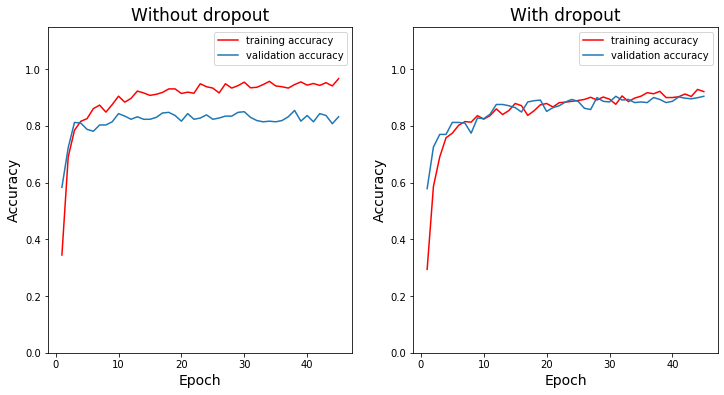

In [56]:
fig = plt.figure(figsize=(12,6))

ax1 = plt.subplot(1,2,1)   

plt.plot(range(1,46), Tracc, label='training accuracy', color = 'r')
plt.plot(range(1,46), Teacc, label='validation accuracy', color = '#1f77b4')
plt.ylim(0,1.15)
plt.xlabel('Epoch',fontsize=14)
plt.ylabel('Accuracy',fontsize=14)
plt.title('Without dropout',fontsize=17)
plt.legend()

ax2 = plt.subplot(1,2,2)

plt.plot(range(1,46), Tracc2, label='training accuracy', color = 'r')
plt.plot(range(1,46), dd, label='validation accuracy', color = '#1f77b4')
plt.xlabel('Epoch',fontsize=14)
plt.ylabel('Accuracy',fontsize=14)
plt.ylim(0,1.15)
plt.title('With dropout',fontsize=17)
plt.legend()
plt.savefig('./transferResult.png')
plt.show()